In [1]:
import numpy as np
import jax.numpy as jnp
import jax

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
BLD = "../../../bld"

seed = 2024

n_choices = 12
n_agents = 10_000

In [3]:
MIN_AGE = 50
MAX_AGE = 65

AGE_50 = 50
AGE_53 = 53
AGE_56 = 56
AGE_59 = 59
AGE_62 = 62

AGE_55 = 55
AGE_60 = 60
AGE_65 = 65

GOOD_HEALTH = 0
MEDIUM_HEALTH = 1
BAD_HEALTH = 2

In [4]:
AGE_BINS = [(AGE_50, AGE_55), (AGE_55, AGE_60), (AGE_60, AGE_65)]
AGE_BINS_FINE = [
    (AGE_50, AGE_53),
    (AGE_53, AGE_56),
    (AGE_56, AGE_59),
    (AGE_59, AGE_62),
    (AGE_62, AGE_65),
]

In [5]:
ALL = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

NO_WORK = [0, 1, 2, 3]
PART_TIME = [4, 5, 6, 7]
FULL_TIME = [8, 9, 10, 11]
WORK = PART_TIME + FULL_TIME


NO_CARE = [0, 4, 8]
FORMAL_CARE = [1, 3, 5, 7, 9, 11]  # % 2 == 1
INFORMAL_CARE = [2, 3, 6, 7, 10, 11]
ANY_CARE = FORMAL_CARE + INFORMAL_CARE
COMBINATION_CARE = [3, 7, 11]

# NO_INFORMAL_CARE = [0, 1, 4, 5, 8, 9] # check!
# NO_FORMAL_CARE = [0, 2, 4, 6, 8, 10]
NO_INFORMAL_CARE = list(set(ANY_CARE) - (set(INFORMAL_CARE)))
NO_FORMAL_CARE = list(set(ALL) - (set(FORMAL_CARE)))

In [6]:
def is_not_working(lagged_choice):
    return lagged_choice in NO_WORK


def is_part_time(lagged_choice):
    return lagged_choice in PART_TIME


def is_full_time(lagged_choice):
    return lagged_choice in FULL_TIME


def is_informal_care(lagged_choice):
    # intensive only here
    return lagged_choice in INFORMAL_CARE


def is_no_informal_care(lagged_choice):
    # intensive only here
    return lagged_choice not in INFORMAL_CARE


def is_formal_care(lagged_choice):
    return lagged_choice in FORMAL_CARE


def is_no_formal_care(lagged_choice):
    return lagged_choice not in FORMAL_CARE

In [7]:
is_no_formal_care(0)

True

# 0. Draw Initial conditions

In [8]:
def get_initial_share_three(initial_conditions, shares):
    return jnp.asarray(initial_conditions.loc[shares]).ravel()


def get_initial_share_two(initial_conditions, var):
    share_yes = initial_conditions.loc[var]
    return jnp.asarray([1 - share_yes, share_yes]).ravel()


def draw_random_sequence_from_array(seed, arr, n_agents):
    """Draw a random sequence from an array.

    rand = draw_random_sequence_from_array(     seed=2024,     n_agents=10_000,
    arr=jnp.array(initial_wealth), )

    """
    key = jax.random.PRNGKey(seed)
    return jax.random.choice(key, arr, shape=(n_agents,), replace=True)


def draw_random_array(seed, n_agents, values, probabilities):
    """Draw a random array with given probabilities.

    Usage:

    seed = 2024
    n_agents = 10_000

    # Parameters
    values = jnp.array([-1, 0, 1, 2])  # Values to choose from
    probabilities = jnp.array([0.3, 0.3, 0.2, 0.2])  # Corresponding probabilities

    table(pd.DataFrame(random_array)[0]) / 1000

    """
    key = jax.random.PRNGKey(seed)
    return jax.random.choice(key, values, shape=(n_agents,), p=probabilities)


def draw_parental_age(seed, n_agents, mean, std_dev):
    """Draw discrete parental age."""
    key = jax.random.PRNGKey(seed)

    sample_standard_normal = jax.random.normal(key, (n_agents,))

    # Scaling and shifting to get the desired mean and standard deviation, then rounding
    return jnp.round(mean + std_dev * sample_standard_normal).astype(jnp.int32)


def _plot_dist(sample):
    sns.histplot(sample, bins=40, kde=True, color="purple")
    # plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Distribution")
    plt.show()

In [9]:
path = f"{BLD}/moments/initial_wealth_at_age_50.csv"
initial_wealth_empirical = jnp.asarray(pd.read_csv(path)).ravel()

In [10]:
path = f"{BLD}/moments/initial_discrete_conditions_at_age_50.csv"
initial_conditions = pd.read_csv(path, index_col=0)

In [11]:
initial_conditions

,moment
share_has_sister,0.537708
share_has_sibling,0.744326
share_married,0.719753
share_not_working,0.278238
share_part_time,0.350928
share_full_time,0.370834
share_informal_care,0.040574
mother_age_mean,76.367568
mother_age_std,4.199512
father_age_mean,77.471698


In [12]:
# choices
employment = get_initial_share_three(
    initial_conditions,
    ["share_not_working", "share_part_time", "share_full_time"],
)
# informal_care = get_initial_share_two(initial_conditions, "share_informal_care")
informal_care = jnp.array([1, 0])  # agents start with no informal care provided
formal_care = jnp.array([1, 0])  # agents start with no formal care provided

In [13]:
employment

Array([0.2782375 , 0.3509282 , 0.37083426], dtype=float32)

In [14]:
informal_care

Array([1, 0], dtype=int32)

In [15]:
formal_care

Array([1, 0], dtype=int32)

In [16]:
informal_formal = jnp.outer(informal_care, formal_care)
# no_informal_no_formal, no_informal_formal
# informal_no_formal, informal_formal

In [17]:
# ALL = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#
# NO_WORK = [0, 1, 2, 3]
# PART_TIME = [4, 5, 6, 7]
# FULL_TIME = [8, 9, 10, 11]
# WORK = PART_TIME + FULL_TIME
#
#
# NO_CARE = [0, 4, 8]
# FORMAL_CARE = [1, 3, 5, 7, 9, 11]  # % 2 == 1
# INFORMAL_CARE = [2, 3, 6, 7, 10, 11]
# ANY_CARE = FORMAL_CARE + INFORMAL_CARE
# COMBINATION_CARE = [3, 7, 11]
#
# # NO_INFORMAL_CARE = [0, 1, 4, 5, 8, 9] # check!
# # NO_FORMAL_CARE = [0, 2, 4, 6, 8, 10]
# NO_INFORMAL_CARE = list(set(ANY_CARE) - (set(INFORMAL_CARE)))
# NO_FORMAL_CARE =list(set(ALL) - (set(FORMAL_CARE)))

lagged_choice_probs = jnp.outer(employment, informal_formal).flatten()

In [18]:
# endogenous states
married = get_initial_share_two(initial_conditions, "share_married")
has_sibling = get_initial_share_two(initial_conditions, "share_has_sibling")

# exogenous states
mother_alive = get_initial_share_two(initial_conditions, "share_mother_alive")
father_alive = get_initial_share_two(initial_conditions, "share_father_alive")

mother_health = get_initial_share_three(
    initial_conditions,
    ["mother_good_health", "mother_medium_health", "mother_bad_health"],
)
father_health = get_initial_share_three(
    initial_conditions,
    ["father_good_health", "father_medium_health", "father_bad_health"],
)

### Draw random

In [19]:
initial_resources = draw_random_sequence_from_array(
    seed,
    initial_wealth_empirical,
    n_agents=n_agents,
)

In [20]:
initial_states = {
    "period": np.zeros(n_agents, dtype=np.int16),
    "lagged_choice": draw_random_array(
        seed=seed + 1,
        n_agents=n_agents,
        values=jnp.arange(n_choices),
        probabilities=lagged_choice_probs,
    ),
    "married": draw_random_array(
        seed=seed + 2,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=married,
    ),
    "has_sibling": draw_random_array(
        seed=seed + 3,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=has_sibling,
    ),
    "mother_age": draw_parental_age(
        seed=seed + 4,
        n_agents=n_agents,
        mean=jnp.asarray(initial_conditions.loc["mother_age_mean"]),
        std_dev=jnp.asarray(initial_conditions.loc["mother_age_std"]),
    ),
    "father_age": draw_parental_age(
        seed=seed + 5,
        n_agents=n_agents,
        mean=jnp.asarray(initial_conditions.loc["father_age_mean"]),
        std_dev=jnp.asarray(initial_conditions.loc["father_age_std"]),
    ),
    # exogenous states
    "mother_alive": draw_random_array(
        seed=seed + 6,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=mother_alive,
    ),
    "father_alive": draw_random_array(
        seed=seed + 7,
        n_agents=n_agents,
        values=jnp.array([0, 1]),
        probabilities=father_alive,
    ),
    "mother_health": draw_random_array(
        seed=seed + 8,
        n_agents=n_agents,
        values=jnp.array([0, 1, 2]),
        probabilities=mother_health,
    ),
    "father_health": draw_random_array(
        seed=seed + 9,
        n_agents=n_agents,
        values=jnp.array([0, 1, 2]),
        probabilities=father_health,
    ),
    "care_demand": np.zeros(n_agents, dtype=np.int16),
}

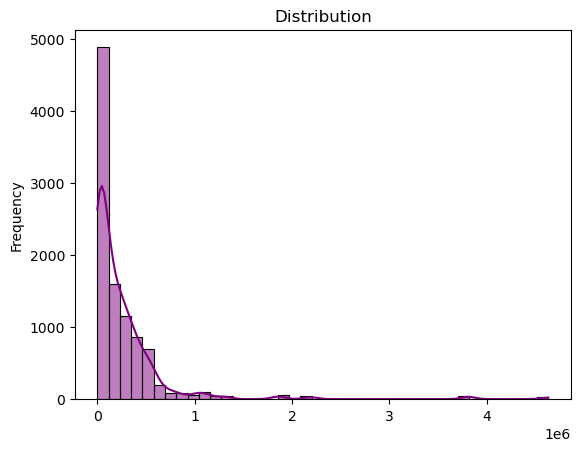

In [21]:
_plot_dist(initial_resources)

In [22]:
initial_states

{'period': array([0, 0, 0, ..., 0, 0, 0], dtype=int16),
 'lagged_choice': Array([0, 0, 8, ..., 4, 0, 8], dtype=int32),
 'married': Array([1, 0, 0, ..., 1, 1, 1], dtype=int32),
 'has_sibling': Array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 'mother_age': Array([73, 86, 74, ..., 79, 78, 72], dtype=int32),
 'father_age': Array([76, 73, 78, ..., 96, 69, 78], dtype=int32),
 'mother_alive': Array([1, 1, 0, ..., 1, 1, 1], dtype=int32),
 'father_alive': Array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 'mother_health': Array([1, 0, 2, ..., 1, 1, 1], dtype=int32),
 'father_health': Array([0, 1, 0, ..., 0, 1, 1], dtype=int32),
 'care_demand': array([0, 0, 0, ..., 0, 0, 0], dtype=int16)}

In [23]:
initial_states["mother_age"].mean(), initial_states["mother_age"].std()

(Array(76.3378, dtype=float32), Array(4.183526, dtype=float32))

In [24]:
initial_states["father_age"].mean(), initial_states["father_age"].std()

(Array(77.4143, dtype=float32), Array(4.114809, dtype=float32))

In [25]:
initial_conditions.loc["mother_age_mean"], initial_conditions.loc["mother_age_std"]

(moment    76.367568
 Name: mother_age_mean, dtype: float64,
 moment    4.199512
 Name: mother_age_std, dtype: float64)

In [26]:
initial_conditions.loc["father_age_mean"], initial_conditions.loc["father_age_std"]

(moment    77.471698
 Name: father_age_mean, dtype: float64,
 moment    4.110863
 Name: father_age_std, dtype: float64)

# 1. Simulation

In [27]:
def create_simulation_df(sim_dict):
    n_periods, n_agents, n_choices = sim_dict["taste_shocks"].shape

    keys_to_drop = ["taste_shocks"]
    dict_to_df = {key: sim_dict[key] for key in sim_dict if key not in keys_to_drop}

    return pd.DataFrame(
        {key: val.ravel() for key, val in dict_to_df.items()},
        index=pd.MultiIndex.from_product(
            [np.arange(n_agents)],
            names=["id"],
        ),
    )

In [28]:
def compute_wealth_and_wage(df, params, wage_offer_func):
    df["wealth"] = df["savings"] + df["consumption"]

    df["wage"] = wage_offer_func(df["age"], params)

    return df

In [29]:
def simulate_moments(df):
    """Df has multiindex ["period", "agent"]
    necessary?

    or "agent", "period" as columns.
    "age" is also a column

    .loc needed below?!

    """
    # no_work_by_age_bin = [
    #     len(
    #         df.loc[
    #             (df["age"] > age_bin[0])
    #             & (df["age"] <= age_bin[1])
    #             & (df["lagged_choice"] in NO_WORK)
    #         ]
    #     )
    #     / len(df.loc[(df["age"] > age_bin[0]) & (df["age"] <= age_bin[1])])
    #     for age_bin in AGE_BINS
    # ]

    # share working by age
    share_not_working_by_age = get_share_by_age(df, lagged_choice=NO_WORK)  # 15
    share_working_part_time_by_age = get_share_by_age(df, lagged_choice=PART_TIME)  # 15
    share_working_full_time_by_age = get_share_by_age(df, lagged_choice=FULL_TIME)  # 15

    share_informal_care_by_age_bin = get_share_by_age_bin(
        df,
        lagged_choice=INFORMAL_CARE,
    )

    # yearly net income
    net_income_part_time_by_age_bin = get_income_by_age_bin(df, lagged_choice=PART_TIME)
    net_income_full_time_by_age_bin = get_income_by_by_age_bin(
        df,
        lagged_choice=FULL_TIME,
    )

    # wealth
    wealth_by_age_bin = get_wealth_beginning_of_period_by_age_bin(df)

    # share working by caregiving type (and age bin) --> to be checked
    share_not_working_no_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=NO_WORK,
            care_type=NO_INFORMAL_CARE,
        )
    )
    share_part_time_no_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=PART_TIME,
            care_type=NO_INFORMAL_CARE,
        )
    )
    share_working_full_time_no_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=FULL_TIME,
            care_type=NO_INFORMAL_CARE,
        )
    )

    share_not_working_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=NO_WORK,
            care_type=INFORMAL_CARE,
        )
    )
    share_part_time_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=PART_TIME,
            care_type=INFORMAL_CARE,
        )
    )
    share_full_time_informal_care_by_age_bin = (
        get_share_by_informal_care_type_by_age_bin(
            df,
            lagged_choice=FULL_TIME,
            care_type=INFORMAL_CARE,
        )
    )

    # parent child: mother
    informal_care_by_mother_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=INFORMAL_CARE,
        parent="mother",
        is_other_parent_alive=True,
    )
    formal_care_by_mother_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=FORMAL_CARE,
        parent="mother",
        is_other_parent_alive=True,
    )
    combination_care_by_mother_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=COMBINATION_CARE,
        parent="mother",
        is_other_parent_alive=True,
    )

    informal_care_by_mother_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=INFORMAL_CARE,
        parent="mother",
        is_other_parent_alive=False,
    )
    formal_care_by_mother_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=FORMAL_CARE,
        parent="mother",
        is_other_parent_alive=False,
    )

    combination_care_by_mother_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=COMBINATION_CARE,
        parent="mother",
        is_other_parent_alive=False,
    )

    # parent child: father
    informal_care_by_father_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=INFORMAL_CARE,
        parent="father",
        is_other_parent_alive=True,
    )
    formal_care_by_father_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=FORMAL_CARE,
        parent="father",
        is_other_parent_alive=True,
    )
    combination_care_by_father_health_couple = get_caregiving_status_by_parental_health(
        df,
        care_choice=COMBINATION_CARE,
        parent="father",
        is_other_parent_alive=True,
    )

    informal_care_by_father_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=INFORMAL_CARE,
        parent="father",
        is_other_parent_alive=False,
    )
    formal_care_by_father_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=FORMAL_CARE,
        parent="father",
        is_other_parent_alive=False,
    )
    combination_care_by_father_health_single = get_caregiving_status_by_parental_health(
        df,
        care_choice=COMBINATION_CARE,
        parent="father",
        is_other_parent_alive=False,
    )

    # work transitions
    no_work_to_no_work = get_work_transition(df, NO_WORK, NO_WORK)
    no_work_to_part_time = get_work_transition(df, NO_WORK, PART_TIME)
    no_work_to_full_time = get_work_transition(df, NO_WORK, FULL_TIME)

    part_time_to_no_work = get_work_transition(df, PART_TIME, NO_WORK)
    part_time_to_part_time = get_work_transition(df, PART_TIME, PART_TIME)
    part_time_to_full_time = get_work_transition(df, PART_TIME, FULL_TIME)

    full_time_to_no_work = get_work_transition(df, FULL_TIME, NO_WORK)
    full_time_to_part_time = get_work_transition(df, FULL_TIME, PART_TIME)
    full_time_to_full_time = get_work_transition(df, FULL_TIME, FULL_TIME)

    # caregiving transitions
    no_informal_care_to_no_informal_care = get_work_transition(
        df,
        NO_INFORMAL_CARE,
        NO_INFORMAL_CARE,
    )
    no_informal_care_to_informal_care = get_work_transition(
        df,
        NO_INFORMAL_CARE,
        INFORMAL_CARE,
    )

    informal_care_to_no_informal_care = get_work_transition(
        df,
        INFORMAL_CARE,
        NO_INFORMAL_CARE,
    )
    informal_care_to_informal_care = get_work_transition(
        df,
        INFORMAL_CARE,
        INFORMAL_CARE,
    )

    no_informal_care_to_no_formal_care = get_work_transition(
        df,
        NO_INFORMAL_CARE,
        NO_FORMAL_CARE,
    )
    no_informal_care_to_formal_care = get_work_transition(
        df,
        NO_INFORMAL_CARE,
        FORMAL_CARE,
    )

    informal_care_to_no_formal_care = get_work_transition(
        df,
        INFORMAL_CARE,
        NO_FORMAL_CARE,
    )
    informal_care_to_formal_care = get_work_transition(df, INFORMAL_CARE, FORMAL_CARE)

    no_formal_care_to_no_informal_care = get_work_transition(
        df,
        NO_FORMAL_CARE,
        NO_INFORMAL_CARE,
    )
    no_formal_care_to_informal_care = get_work_transition(
        df,
        NO_FORMAL_CARE,
        INFORMAL_CARE,
    )

    formal_care_to_no_informal_care = get_work_transition(
        df,
        FORMAL_CARE,
        NO_INFORMAL_CARE,
    )
    formal_care_to_informal_care = get_work_transition(df, FORMAL_CARE, INFORMAL_CARE)

    no_formal_care_to_no_formal_care = get_work_transition(
        df,
        NO_FORMAL_CARE,
        NO_FORMAL_CARE,
    )
    no_formal_care_to_formal_care = get_work_transition(df, NO_FORMAL_CARE, FORMAL_CARE)

    formal_care_to_no_formal_care = get_work_transition(df, FORMAL_CARE, NO_FORMAL_CARE)
    formal_care_to_formal_care = get_work_transition(df, FORMAL_CARE, FORMAL_CARE)

    return jnp.array(
        [
            share_not_working_by_age,
            share_working_part_time_by_age,
            share_working_full_time_by_age,
            share_informal_care_by_age_bin,
            net_income_part_time_age_bin,
            net_income_full_time_age_bin,
            wealth_by_age_bin,
            share_not_working_no_informal_care,
            share_part_time_no_informal_care,
            share_full_time_no_informal_care,
            share_not_working_informal_care,
            share_part_time_informal_care,
            share_full_time_informal_care,
            informal_care_by_mother_health_couple,
            formal_care_by_mother_health_couple,
            combination_care_by_mother_health_couple,
            informal_care_by_mother_health_single,
            formal_care_by_mother_health_single,
            combination_care_by_mother_health_single,
            informal_care_by_father_health_couple,
            formal_care_by_father_health_couple,
            combination_care_by_father_health_couple,
            informal_care_by_father_health_single,
            formal_care_by_father_health_single,
            combination_care_by_father_health_single,
            # work transitions
            no_work_to_no_work,
            no_work_to_part_time,
            no_work_to_full_time,
            part_time_to_no_work,
            part_time_to_part_time,
            part_time_to_full_time,
            full_time_to_no_work,
            full_time_to_part_time,
            full_time_to_full_time,
            # caregiving transitions
            no_informal_care_to_no_informal_care,
            no_informal_care_to_informal_care,
            informal_care_to_no_informal_care,
            informal_care_to_informal_care,
            no_informal_care_to_no_formal_care,
            no_informal_care_to_formal_care,
            informal_care_to_no_formal_care,
            informal_care_to_formal_care,
            no_formal_care_to_no_informal_care,
            no_formal_care_to_informal_care,
            formal_care_to_no_informal_care,
            formal_care_to_informal_care,
            no_formal_care_to_no_formal_care,
            no_formal_care_to_formal_care,
            formal_care_to_no_formal_care,
            formal_care_to_formal_care,
        ],
    )

In [30]:
def get_share_by_age(df, lagged_choice):
    return [
        len(df[(df["age"] == age) & (df["lagged_choice"].isin(lagged_choice))])
        / len(df[(df["age"] == age)])
        for age in range(MIN_AGE + 1, MAX_AGE + 1)
    ]

In [31]:
def get_share_by_age_bin(df, lagged_choice):
    return [
        len(
            df[
                (df["age"] > age_bin[0])
                & (df["age"] <= age_bin[1])
                & (df["lagged_choice"].isin(lagged_choice))
            ],
        )
        / len(df[(df["age"] > age_bin[0]) & (df["age"] <= age_bin[1])])
        for age_bin in AGE_BINS
    ]

In [32]:
def get_share_by_informal_care_type_by_age_bin(df, lagged_choice, care_type):
    """Really lagged choice or rather current (end of period) choice?"""
    return [
        len(
            df[
                (df["age"] > age_bin[0])
                & (df["age"] <= age_bin[1])
                & (df["lagged_choice"].isin(care_type))
                & (df["lagged_choice"].isin(lagged_choice))
            ],
        )
        / len(
            df[
                (df["age"] > age_bin[0])
                & (df["age"] <= age_bin[1])
                & (df["lagged_choice"].isin(care_type))
            ],
        )
        for age_bin in AGE_BINS
    ]

In [33]:
def _get_share_by_informal_care_type(df, lagged_choice, care_type):
    """Really lagged choice or rather current (end of period) choice?"""
    return [
        len(
            df[
                (df["lagged_choice"].isin(care_type))
                & (df["lagged_choice"].isin(lagged_choice))
            ],
        )
        / len(df[(df["lagged_choice"].isin(care_type))]),
    ]

In [34]:
def get_income_by_age_bin(df, lagged_choice):
    """Net income in absolute (non-log) terms

    After taxes and transfers as reported in SHARE.
    """
    df["working_hours"] = (
        df[(df["lagged_choice"].isin(PART_TIME))] * PART_TIME_HOURS
        + df[(df["lagged_choice"].isin(FULL_TIME))] * FULL_TIME_HOURS
    )
    df["income"] = df["working_hours"] * df["wage"]

    return [
        df.loc[(df["age"] > age_bin[0]) & (df["age"] <= age_bin[1]), "income"].mean()
        for age in AGE_BINS
    ]

In [35]:
def get_income_by_age(df, lagged_choice):
    """Net income in absolute (non-log) terms

    After taxes and transfers as reported in SHARE.
    """
    df["working_hours"] = (
        df[(df["lagged_choice"].isin(PART_TIME))] * PART_TIME_HOURS
        + df[(df["lagged_choice"].isin(FULL_TIME))] * FULL_TIME_HOURS
    )
    df["income"] = df["working_hours"] * df["wage"]

    return [
        df.loc[(df["age"] == age), "income"].mean()
        for age in range(MIN_AGE + 1, MAX_AGE + 1)
    ]

In [36]:
def get_wealth_beginning_of_period_by_age_bin(df):
    """savings_current_period = resources_beginning_of_period - consumption

    beginning or end of period wealth?
    end of period wealth = savings

    matter of whether consumption is included or not (part of income that is consumed)

    """
    return [
        df.loc[(df["age"] > age_bin[0]) & (df["age"] <= age_bin[1]), "wealth"].mean()
        for age_bin in AGE_BINS
    ]

In [37]:
def _get_share_by_informal_care_type_by_age_bin(
    df,
    lagged_choice,
    is_informal_care,
):
    """Duplicate? What's the difference?"""
    return [
        len(
            df[
                (df["lagged_choice"].isin(INFORMAL_CARE) * is_informal_care)
                & (df["age"] > age_bin[0])
                & (df["age"] <= age_bin[1])
                & (df["lagged_choice"].isin(lagged_choice))
            ],
        )
        / len(
            df[
                (df["lagged_choice"].isin(INFORMAL_CARE) * is_informal_care)
                & (df["age"] > age_bin[0])
                & (df["age"] <= age_bin[1])
            ],
        )
        for age_bin in AGE_BINS
    ]

In [38]:
def get_caregiving_status_by_parental_health(
    df,
    care_choice,
    parent,
    is_other_parent_alive,
):
    other_parent = ("father") * (parent == "mother") + ("mother") * (parent == "father")

    return [
        len(
            df[
                (df[f"{parent}_health"] == health)
                & (df[f"{other_parent}_alive"] == is_other_parent_alive)
                & (df["choice"].isin(care_choice))
            ],
        )
        for health in [GOOD_HEALTH, MEDIUM_HEALTH, BAD_HEALTH]
    ]

In [39]:
def get_work_transition(lagged_choice, current_choice):
    """df[(df["lagged_choice"].isin(NO_WORK)) & (df["choice"].isin(NO_WORK))]"""
    return len(
        df[
            (df["lagged_choice"].isin(lagged_choice))
            & (df["choice"].isin(current_choice))
        ],
    ) / len(df[(df["lagged_choice"].isin(lagged_choice))])

In [40]:
def get_care_transition(lagged_choice, current_choice):
    """ """
    return len(
        df[
            (df["lagged_choice"].isin(lagged_choice))
            & (df["choice"].isin(current_choice))
        ],
    ) / len(df[(df["lagged_choice"].isin(lagged_choice))])